In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pathlib
import zipfile

import pandas as pd

import src.utils.misc as misc

In [4]:
data = pathlib.Path('..') / 'data'
pkls = data / 'pkls'
essay_zip = data / 'asap-aes.zip'

with zipfile.ZipFile(essay_zip) as zf:
    tsvs = misc.stream_extract(zf, 7, 5, 11)
    train, valid, test = (pd.read_csv(tsv, delimiter='\t', encoding='latin-1') for tsv in tsvs)
    
    csv = next(misc.stream_extract(zf, 4))
    valid_map = (pd.read_csv(csv)
                   .set_index(['prediction_id'])
                   .to_dict()
                   .pop('predicted_score'))

    descr_zip = next(misc.stream_extract(zf, 1))
        
    
with zipfile.ZipFile(descr_zip) as zf:
    descr_xlsx = next(misc.stream_extract(zf, 8))
    descr = pd.read_excel(descr_xlsx)

    readmes = misc.stream_extract(zf, *range(8))
    prompts = [misc.get_prompt(readme) for readme in readmes]

# Descriptions

In [5]:
cols = [col for col in descr.columns if any(string in col for string in ['size', 'has'])]
descr = descr.drop(columns=cols)

domain2_min_max = ['min_domain2_score', 'max_domain2_score']
descr[domain2_min_max] = descr[domain2_min_max].astype("Int64")

descr['prompt'] = prompts

descr.to_pickle(pkls / 'descr.pkl')
descr

,essay_set,type_of_essay,grade_level,min_domain1_score,max_domain1_score,min_domain2_score,max_domain2_score,prompt
0,1,persuasive / narrative / expository,8,2,12,NaN,NaN,"More and more people use computers, but not ev..."
1,2,persuasive / narrative / expository,10,1,6,1,4,"Censorship in the Libraries\n""All of us can th..."
2,3,source dependent responses,10,0,3,NaN,NaN,Write a response that explains how the feature...
3,4,source dependent responses,10,0,3,NaN,NaN,"Read the last paragraph of the story.\n\n""When..."
4,5,source dependent responses,8,0,4,NaN,NaN,Describe the mood created by the author in the...
5,6,source dependent responses,10,0,4,NaN,NaN,"Based on the excerpt, describe the obstacles t..."
6,7,persuasive / narrative / expository,7,0,30,NaN,NaN,Write about patience. Being patient means that...
7,8,persuasive / narrative / expository,10,0,60,NaN,NaN,We all understand the benefits of laughter. Fo...


In [6]:
interp_domain1 = misc.interpolate(descr, 'min_domain1_score', 'max_domain1_score')
interp_domain2 = misc.interpolate(descr, 'min_domain2_score', 'max_domain2_score')

def map_scores(df):
    dom1_per = []
    groups = df['domain1_score'].groupby(df['essay_set'])
    for (_, group), interp in zip(groups, interp_domain1):
        dom1_per.append(group.map(interp))

    dom2_per = []
    groups = df['domain2_score'].groupby(df['essay_set'])
    for (_, group), interp in zip(groups, interp_domain2):
        dom2_per.append(group.map(interp))

    df = df.copy()
    df['domain1_percent'] = pd.concat(dom1_per)
    df['domain2_percent'] = pd.concat(dom2_per)
    return df

# Train

In [7]:
train = train.drop(columns=[col for col in train.columns if 'rater' in col])
train['domain2_score'] = train['domain2_score'].astype("Int64")
train = map_scores(train)

train.to_pickle(pkls / 'train.pkl')
train.head()

,essay_id,essay_set,essay,domain1_score,domain2_score,domain1_percent,domain2_percent
0,1,1,"Dear local newspaper, I think effects computer...",8,NaN,60.0,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,NaN,70.0,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,NaN,50.0,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,NaN,80.0,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,NaN,60.0,NaN


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 7 columns):
essay_id           12976 non-null int64
essay_set          12976 non-null int64
essay              12976 non-null object
domain1_score      12976 non-null int64
domain2_score      1800 non-null Int64
domain1_percent    12976 non-null float64
domain2_percent    1800 non-null float64
dtypes: Int64(1), float64(2), int64(3), object(1)
memory usage: 722.4+ KB


In [9]:
train.describe()

,essay_id,essay_set,domain1_score,domain2_score,domain1_percent,domain2_percent
count,12976.000000,12976.000000,12976.000000,1800.000000,12976.000000,1800.000000
mean,10295.395808,4.179485,6.800247,3.333889,58.093789,77.796296
std,6309.074105,2.136913,8.970705,0.729103,23.424215,24.303436
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,4438.750000,2.000000,2.000000,3.000000,40.000000,66.666667
50%,10044.500000,4.000000,3.000000,3.000000,60.000000,66.666667
75%,15681.250000,6.000000,8.000000,4.000000,75.000000,100.000000
max,21633.000000,8.000000,60.000000,4.000000,100.000000,100.000000


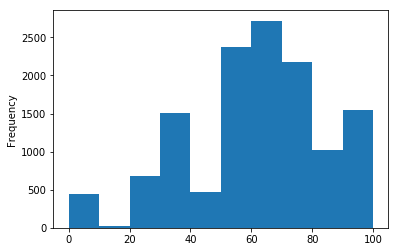

In [12]:
train[['domain1_percent', 'domain2_percent']].mean(axis=1).plot.hist();

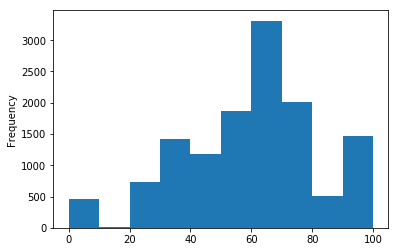

In [13]:
train['domain1_percent'].plot.hist();

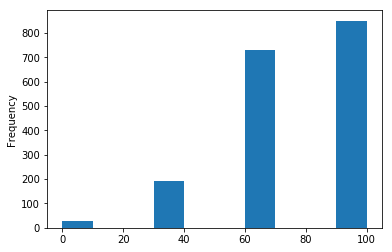

In [14]:
train['domain2_percent'].plot.hist();

# Validation

In [15]:
valid['domain1_score'] = valid['domain1_predictionid'].map(valid_map)
valid['domain2_score'] = valid['domain2_predictionid'].map(valid_map).astype("Int64")
valid = valid.drop(columns=[col for col in valid.columns if 'predictionid' in col])
valid = map_scores(valid)

valid.to_pickle(pkls / 'valid.pkl')
valid.head()

,essay_id,essay_set,essay,domain1_score,domain2_score,domain1_percent,domain2_percent
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",7,NaN,50.0,NaN
1,1789,1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,8,NaN,60.0,NaN
2,1790,1,"Dear Local newspaper, Have you been spending a...",9,NaN,70.0,NaN
3,1791,1,"Dear Readers, @CAPS1 you imagine how life woul...",9,NaN,70.0,NaN
4,1792,1,"Dear newspaper, I strongly believe that comput...",9,NaN,70.0,NaN


In [16]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4218 entries, 0 to 4217
Data columns (total 7 columns):
essay_id           4218 non-null int64
essay_set          4218 non-null int64
essay              4218 non-null object
domain1_score      4218 non-null int64
domain2_score      600 non-null Int64
domain1_percent    4218 non-null float64
domain2_percent    600 non-null float64
dtypes: Int64(1), float64(2), int64(3), object(1)
memory usage: 234.9+ KB


In [17]:
valid.describe()

,essay_id,essay_set,domain1_score,domain2_score,domain1_percent,domain2_percent
count,4218.000000,4218.000000,4218.000000,600.000000,4218.000000,600.000000
mean,11282.446420,4.123518,6.654576,3.331667,59.460250,77.722222
std,6173.633131,2.117188,8.799343,0.639541,21.576926,21.318022
min,1788.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,5243.250000,2.000000,2.000000,3.000000,43.750000,66.666667
50%,10995.500000,4.000000,3.000000,3.000000,60.000000,66.666667
75%,16852.750000,6.000000,8.000000,4.000000,75.000000,100.000000
max,21938.000000,8.000000,50.000000,4.000000,100.000000,100.000000


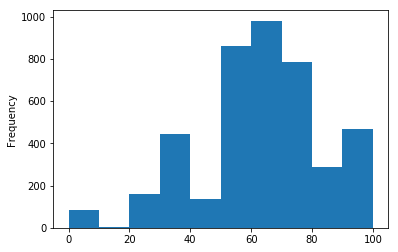

In [18]:
valid[['domain1_percent', 'domain2_percent']].mean(axis=1).plot.hist();

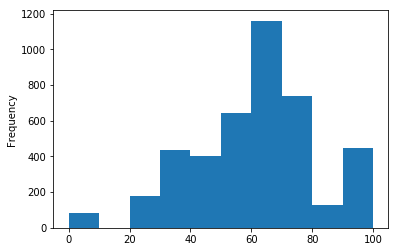

In [19]:
valid['domain1_percent'].plot.hist();

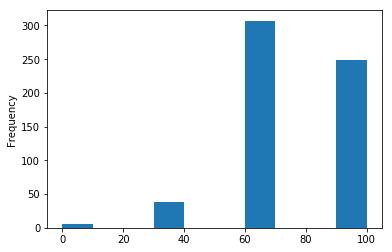

In [20]:
valid['domain2_percent'].plot.hist();

# Test

In [21]:
test.to_pickle(pkls / 'test.pkl')
test.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,I believe that computers have a positive effec...,2383,NaN
1,2384,1,"Dear @CAPS1, I know some problems have came up...",2384,NaN
2,2385,1,"Dear to whom it @MONTH1 concern, Computers are...",2385,NaN
3,2386,1,"Dear @CAPS1 @CAPS2, @CAPS3 has come to my atte...",2386,NaN
4,2387,1,"Dear Local newspaper, I think that people have...",2387,NaN


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4254 entries, 0 to 4253
Data columns (total 5 columns):
essay_id                4254 non-null int64
essay_set               4254 non-null int64
essay                   4254 non-null object
domain1_predictionid    4254 non-null int64
domain2_predictionid    600 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 166.2+ KB


In [23]:
test.describe()

,essay_id,essay_set,domain1_predictionid,domain2_predictionid
count,4254.000000,4254.000000,4254.000000,600.000000
mean,11922.108134,4.146685,14460.824636,8378.000000
std,6182.143429,2.132264,6896.586714,346.698716
min,2383.000000,1.000000,2383.000000,7779.000000
25%,5847.250000,2.000000,8716.500000,8078.500000
50%,11605.500000,4.000000,14605.500000,8378.000000
75%,17475.750000,6.000000,20475.750000,8677.500000
max,22242.000000,8.000000,25242.000000,8977.000000
